In [1]:
import re
from collections import namedtuple

import numpy as np
import pandas as pd
import shap
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

shap.initjs()


def camel_to_snake(text):
    return re.sub(r"(?<!^)(?=[A-Z])", "_", text).lower()


def return_clf_score(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    precision = precision_score(y_true, y_pred, average="weighted", zero_division=0.0)
    recall = recall_score(y_true, y_pred, average="weighted")
    matrix = confusion_matrix(y_true, y_pred, normalize="true")
    Scores = namedtuple("Scores", ["acc", "f1", "precision", "recall", "matrix"])
    return Scores(acc, f1, precision, recall, matrix)

# Data Preparation

In [2]:
# load df
path = "input/gender_classification_v7.csv"
df = pd.read_csv(path)

# change gender to gender_male
df["gender_male"] = df["gender"].map({"Male": 1, "Female": 0})
df = df.drop(columns=["gender"])

# see df
df.head()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender_male
0,1,11.8,6.1,1,0,1,1,1
1,0,14.0,5.4,0,0,1,0,0
2,0,11.8,6.3,1,1,1,1,1
3,0,14.4,6.1,0,1,1,1,1
4,1,13.5,5.9,0,0,0,0,0


In [3]:
df["gender_male"].value_counts()

gender_male
0    2501
1    2500
Name: count, dtype: int64

In [4]:
df.columns

Index(['long_hair', 'forehead_width_cm', 'forehead_height_cm', 'nose_wide',
       'nose_long', 'lips_thin', 'distance_nose_to_lip_long', 'gender_male'],
      dtype='object')

In [5]:
# split into train and test set
x = df.drop(columns=["gender_male"])
y = df["gender_male"].copy()
x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=0.8, shuffle=True, stratify=df["gender_male"].values
)
y_train = y_train.values
y_test = y_test.values

# encode amd scale features

num_cols = ["forehead_width_cm", "forehead_height_cm"]
cat_cols = [
    "long_hair",
    "nose_wide",
    "nose_long",
    "lips_thin",
    "distance_nose_to_lip_long",
]
num_pipeline = Pipeline([
    ("minmax", MinMaxScaler()),
])
cat_pipeline = Pipeline([
    # the cat features has been OHE so no need to do it again
    ("minmax", MinMaxScaler()),
])
preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols),
])
x_train_preprocessed = preprocessing.fit_transform(x_train)
x_test_preprocessed = preprocessing.transform(x_test)

x_train_preprocessed.shape, x_test_preprocessed.shape

((4000, 7), (1001, 7))

# Test Model

In [6]:
# specify model to test
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
lr = LogisticRegression()
ridge = RidgeClassifier()
perceptron = Perceptron()
svc = SVC()
gaussian = GaussianProcessClassifier()
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier()
mlp = MLPClassifier(max_iter=1000)
models = [rf, gb, lr, ridge, perceptron, svc, gaussian, dt, knn, mlp]

# test individual model
print()
print("Validating individual models:")
result = {}
for model in models:
    model_name = model.__class__.__name__
    scores = cross_val_score(model, x_train_preprocessed, y_train, scoring="f1", cv=3)
    result[model_name] = scores

result = {
    k: np.mean(v)
    for k, v in sorted(result.items(), key=lambda item: np.mean(item[1]), reverse=True)
}
for k, v in result.items():
    print(f"    {k}: F1 score {v:.4f}")


Validating individual models:
    GradientBoostingClassifier: F1 score 0.9716
    RandomForestClassifier: F1 score 0.9690
    RidgeClassifier: F1 score 0.9674
    LogisticRegression: F1 score 0.9665
    MLPClassifier: F1 score 0.9647
    GaussianProcessClassifier: F1 score 0.9640
    KNeighborsClassifier: F1 score 0.9599
    SVC: F1 score 0.9595
    DecisionTreeClassifier: F1 score 0.9574
    Perceptron: F1 score 0.8848


# SHAP

In [7]:
model = GradientBoostingClassifier()
model.fit(x_train_preprocessed, y_train)
y_pred = model.predict(x_test_preprocessed)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       501
           1       0.99      0.96      0.98       500

    accuracy                           0.98      1001
   macro avg       0.98      0.98      0.98      1001
weighted avg       0.98      0.98      0.98      1001



In [8]:
explainer = shap.TreeExplainer(
    model, feature_names=preprocessing.get_feature_names_out()
)
shap_values = explainer(x_test_preprocessed)

In [9]:
shap_values.values.shape

(1001, 7)

## Local interpretability

Prediction:  1


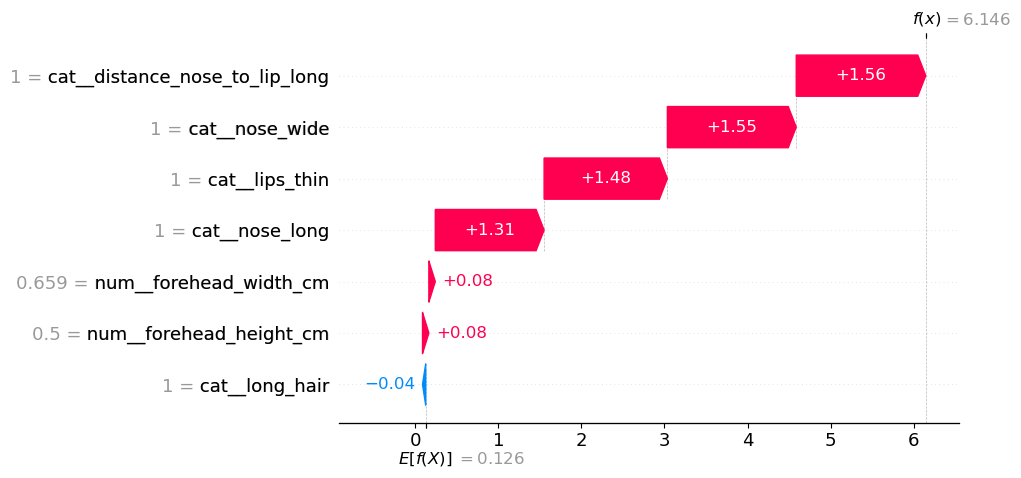

In [10]:
sample_ind = 0  # sample index
# see actual y_pred
print("Prediction: ", y_pred[sample_ind])
# see waterfall plot
shap.plots.waterfall(shap_values[sample_ind], max_display=14)   

In [11]:
print("Prediction: ", y_pred[sample_ind])
shap.plots.force(shap_values[sample_ind])

Prediction:  1


## Global interpretability

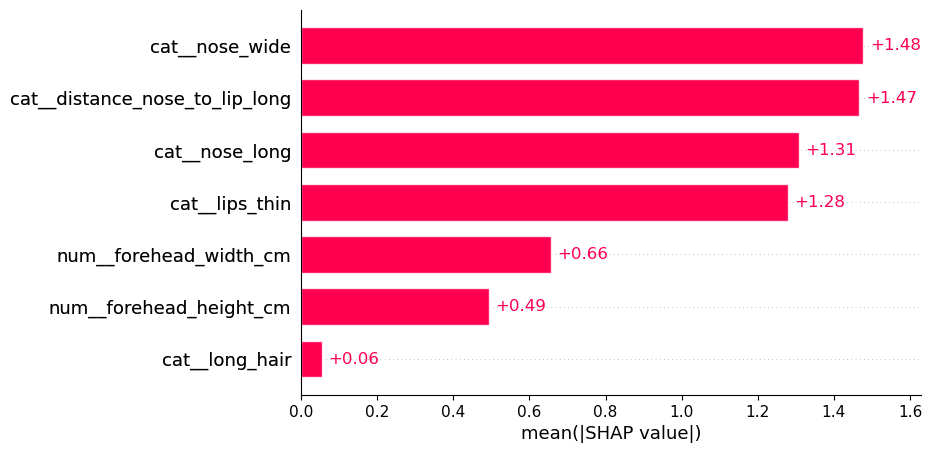

In [12]:
shap.plots.bar(shap_values, max_display=10)

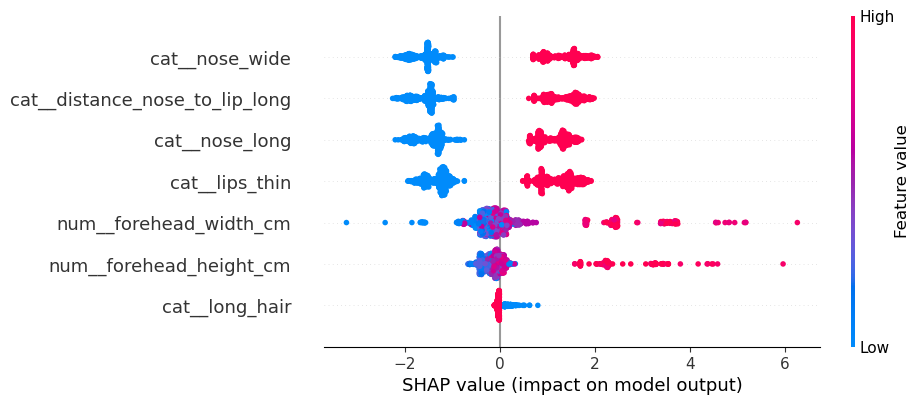

In [13]:
shap.plots.beeswarm(shap_values)

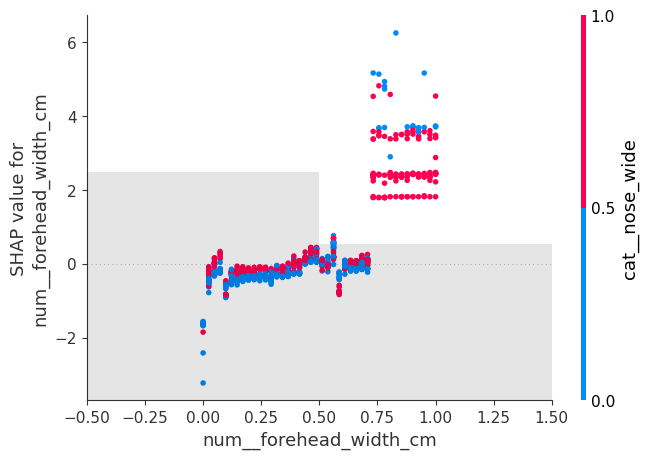

In [31]:
shap.plots.scatter(shap_values[:, 0], color=shap_values)